In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
inf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [4]:
#Drop Lat, Long and Province/State columns
inf.drop(inf.columns[[0, 2, 3]], axis=1, inplace=True)
#Rename the country column name
inf.rename(columns={'Country/Region':'Country'}, inplace=True)
#Group by country to get the sums
inf_g = inf.groupby('Country').sum()
#Unpivot the data to have the dates in a single column and values in another
inf_g = inf_g.unstack().reset_index(name='value')
#Rename the columns to appropriate names
inf_g.rename(columns={'level_0':'Date','value':'TotalInfected'}, inplace=True)

In [5]:
dead=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [6]:
dead.drop(dead.columns[[0, 2, 3]], axis=1, inplace=True)
dead.rename(columns={'Country/Region':'Country'}, inplace=True)
dead_g = dead.groupby('Country').sum()
dead_g = dead_g.unstack().reset_index(name='value')
dead_g.rename(columns={'level_0':'Date','value':'TotalDeaths'}, inplace=True)

In [7]:
recov = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [8]:
recov.drop(recov.columns[[0, 2, 3]], axis=1, inplace=True)
recov.rename(columns={'Country/Region':'Country'}, inplace=True)
recov_g = recov.groupby('Country').sum()
recov_g = recov_g.unstack().reset_index(name='value')
recov_g.rename(columns={'level_0':'Date','value':'TotalRecovered'}, inplace=True)

In [9]:
#Merging all the 3 data frames together
covid = pd.merge(pd.merge(inf_g, dead_g, how='inner', on=['Country','Date']), recov_g, how='inner',on=['Country','Date'])

In [10]:
#Convert the Date field to date datatype
covid['Date']= pd.to_datetime(covid['Date'])

In [11]:
#Ordering and sorting the columns in the dataframe
covid = covid[covid.columns[[1,0,2,3,4]]].sort_values(by=['Country','Date'])

In [12]:
#Adding day numbers to the dataset
covid['Day']=covid[covid['TotalInfected']>0].groupby('Country')['Date'].rank(ascending=True).astype(int)

In [13]:
#Adding daily numbers
covid['Infected'] = covid.groupby('Country')['TotalInfected'].diff(periods=1)
covid['Deaths'] = covid.groupby('Country')['TotalDeaths'].diff(periods=1)
covid['Recovered'] = covid.groupby('Country')['TotalRecovered'].diff(periods=1)

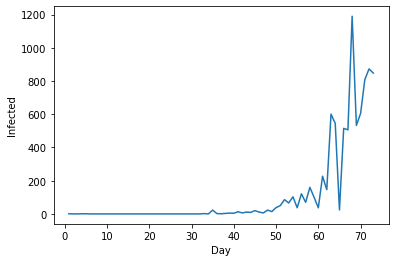

In [14]:
sns.lineplot(x='Day',y='Infected',data=covid[(covid['TotalInfected']>0) & (covid['Country']=='India')])

In [15]:
#get world population data
from bs4 import BeautifulSoup
import requests


In [16]:
url = 'https://www.worldometers.info/world-population/population-by-country/'
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")
#print(soup.prettify()) # print the parsed data of html

In [17]:
pop_table = soup.find("table", attrs={"id": "example2"})
pop_table_data = pop_table.tbody.find_all("tr")
#pop_table_data

In [18]:
# Get all the headings of Lists
t_headers = []
for th in pop_table.find_all("th"):
    # remove any newlines and extra spaces from left and right
    t_headers.append(th.text)
#t_headers

In [19]:
data = {}
table_data = []
for tr in pop_table.tbody.find_all("tr"):
    t_row = {}
    for td, th in zip(tr.find_all("td"), t_headers): 
            t_row[th] = td.text
            table_data.append(t_row)
        # Put the data for the table with his heading.

pop_df = pd.DataFrame(table_data)

In [20]:
pop_df = pop_df.drop_duplicates()
pop_df.rename(columns={'Country (or dependency)':'Country'}, inplace=True)
#pop_df


In [21]:
covid = pd.merge(covid, pop_df[['Country','Population (2020)']], how='left', on='Country')

In [22]:
covid['InfectedRank']=covid.groupby(['Date'])['TotalInfected'].rank(method='max',ascending=False,na_option='bottom')
covid['DeathRank']=covid.groupby(['Date'])['TotalDeaths'].rank(method='max',ascending=False,na_option='bottom')
covid['RecoveredRank']=covid.groupby(['Date'])['TotalRecovered'].rank(method='max',ascending=False,na_option='bottom')

In [23]:
covid[covid['Country']=='India']

,Country,Date,TotalInfected,TotalDeaths,TotalRecovered,Day,Infected,Deaths,Recovered,Population (2020),InfectedRank,DeathRank,RecoveredRank
6318,India,2020-01-22,0,0,0,NaN,NaN,NaN,NaN,"1,380,004,385",185.0,185.0,185.0
6319,India,2020-01-23,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0
6320,India,2020-01-24,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0
6321,India,2020-01-25,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0
6322,India,2020-01-26,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394,India,2020-04-07,5311,150,421,69.0,533.0,14.0,46.0,"1,380,004,385",24.0,26.0,31.0
6395,India,2020-04-08,5916,178,506,70.0,605.0,28.0,85.0,"1,380,004,385",24.0,26.0,28.0
6396,India,2020-04-09,6725,226,620,71.0,809.0,48.0,114.0,"1,380,004,385",21.0,24.0,27.0
6397,India,2020-04-10,7598,246,774,72.0,873.0,20.0,154.0,"1,380,004,385",22.0,24.0,22.0


In [24]:
covid.to_csv('COVID-19Dataset.csv', index = False, header=True)